# Bus Rapid Transit in Los Angeles and Atlanta: Evaluating Service Area Demographics - Aziz and Andrew
Our midterm project included a function and for loop, so for Week 7 we're continuing to clean up our coding process, switching to block group-level data and consolidating data sources, and performing a spatial join with isochrones and block group centroids rather than the entire block group geometry.

Function & For Loops:
* 'for df in census:' drops all statistical error columns from our census data
* 'for gdf in stops:' for a given gdf of bus stops, adds lat and lon columns calculated from geometry if not already included in the gdf
* 'isogen' function: for a given 'place' variable, generates an isochrone (currently set to 10-minute walkshed)
* 'for index,row in ATL_BRT.iterrows():' over each row in the bus stop gdf, creates a 'place variable' from lat and lon columns, runs the isogen function using 'place' as an input, and appends the isochrone produced to the 'output' gdf


## Consolidating Census Data
In this section, we import census tables for race, nativity, commute mode, and population density. Then we clean up the columns and merge all the data into a single gdf. This data covers Los Angeles County, CA and Clayton, Dekalb, and Fulton Counties, GA. Bring some automation to the table cleanup and merging process will make it easier to add new tables quickly if we want to consider other factors in our analysis.

In [2]:
import pandas as pd

import geopandas as gpd

import matplotlib.pyplot as plt

import networkx as nx

import osmnx as ox

import contextily as ctx

from functools import reduce

In [3]:
#auto-delete all census columns w/'Error' in the title
race = gpd.read_file('midterm_data/BG_B03002_race.geojson')
nativity = gpd.read_file('midterm_data/BG_B05012_nativity.geojson')
mode = gpd.read_file('midterm_data/BG_B08301_mode.geojson')
pop_dens = pd.read_csv('midterm_data/pop_dens.csv')
census = [race, nativity, mode, pop_dens]

for df in census:
    df.drop(df.filter(regex='Error').columns, axis=1, inplace=True)

In [4]:
columnstokeep = ['geoid',
 'name',
 'B03002001',
 'B03002002',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002008',
 'B03002009',
 'B03002012',
 'geometry']
race = race[columnstokeep]
race.columns = ['geoid',
 'name',
 'Total',
 'Not Latinx',
 'White',
 'Black',
 'American Indian/Alaska Native',
 'Asian',
 'Native Hawaiian/Other Pacific Islander',
 'Other',
 'Two or more races',
 'Latinx',
 'geometry']

In [5]:
race['Percent Not Latinx'] = race['Not Latinx']/race['Total']*100
race['Percent Latinx'] = race['Latinx']/race['Total']*100
race['Percent White'] = race['White']/race['Total']*100
race['Percent Black'] = race['Black']/race['Total']*100
race['Percent American Indian/Alaska Native'] = race['American Indian/Alaska Native']/race['Total']*100
race['Percent Asian'] = race['Asian']/race['Total']*100
race['Percent Native Hawaiian/Other Pacific Islander'] = race['Native Hawaiian/Other Pacific Islander']/race['Total']*100
race['Percent Other'] = race['Other']/race['Total']*100
race['Percent Two or more races'] = race['Two or more races']/race['Total']*100

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [6]:
columnstokeep = ['geoid',
 'B05012001',
 'B05012002',
 'B05012003']
nativity = nativity[columnstokeep]
nativity.columns=['geoid',
                 'Total',
                 'Native',
                 'Foreign-Born']
nativity['Percent Native'] = nativity['Native']/race['Total']*100
nativity['Percent Foreign-Born'] = nativity['Foreign-Born']/race['Total']*100

<ipython-input-6-828938b64346>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nativity['Percent Native'] = nativity['Native']/race['Total']*100


In [7]:
columnstokeep = ['geoid',
 'B08301001',
 'B08301002',
 'B08301003',
 'B08301004',
 'B08301005',
 'B08301006',
 'B08301007',
 'B08301008',
 'B08301009',
 'B08301010',
 'B08301011',
 'B08301012',
 'B08301013',
 'B08301014',
 'B08301015',
 'B08301016',
 'B08301017',
 'B08301018',
 'B08301019',
 'B08301020',
 'B08301021']
mode = mode[columnstokeep]
mode.columns = ['geoid',
 'Total',
 'Car, truck, or van',
 'Drove alone',
 'Carpooled',
 'In 2-person carpool',
 'In 3-person carpool',
 'In 4-person carpool',
 'In 5- or 6-person carpool',
 'In 7-or-more-person carpool',
 'Public transportation (excluding taxicab)',
 'Bus',
 'Subway or elevated rail',
 'Long-distance train or commuter rail',
 'Light rail, streetcar or trolley', 
 'Ferryboat',
 'Taxicab',
 'Motorcycle',
 'Bicycle',
 'Walked',
 'Other means',
 'Worked from home']
mode['Percent Driving'] = mode['Car, truck, or van']/mode['Total']*100
mode['Percent Public Transit'] = mode['Public transportation (excluding taxicab)']/mode['Total']*100
mode['Percent Biking'] = mode['Bicycle']/mode['Total']*100
mode['Percent Walking'] = mode['Walked']/mode['Total']*100

<ipython-input-7-b2879110c79c>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mode['Percent Driving'] = mode['Car, truck, or van']/mode['Total']*100


In [8]:
#merges all the census tables into a single dataframe and removes duplicate columns
census = [race, nativity, mode, pop_dens]
census_merged = reduce(lambda  left,right: pd.merge(left,right,on=['geoid'],
                                            how='outer', suffixes=('', '_y')), census)
census_merged.drop(census_merged.filter(regex='_y$'),axis=1, inplace=True)
census_merged = gpd.GeoDataFrame(census_merged, geometry='geometry')

In [38]:
pd.set_option('display.max_columns', 100)
census_merged.head()

,geoid,name,Total,Not Latinx,White,Black,American Indian/Alaska Native,Asian,Native Hawaiian/Other Pacific Islander,Other,Two or more races,Latinx,geometry,Percent Not Latinx,Percent Latinx,Percent White,Percent Black,Percent American Indian/Alaska Native,Percent Asian,Percent Native Hawaiian/Other Pacific Islander,Percent Other,Percent Two or more races,Native,Foreign-Born,Percent Native,Percent Foreign-Born,"Car, truck, or van",Drove alone,Carpooled,In 2-person carpool,In 3-person carpool,In 4-person carpool,In 5- or 6-person carpool,In 7-or-more-person carpool,Public transportation (excluding taxicab),Bus,Subway or elevated rail,Long-distance train or commuter rail,"Light rail, streetcar or trolley",Ferryboat,Taxicab,Motorcycle,Bicycle,Walked,Other means,Worked from home,Percent Driving,Percent Public Transit,Percent Biking,Percent Walking,Total Population,Population Density,Area (land),centroid,rep_point
0,15000US060371011101,"Block Group 1, Los Angeles, CA",1688.0,1208.0,1068.0,8.0,0.0,44.0,0.0,0.0,88.0,480.0,"MULTIPOLYGON (((-13168130.287 4063777.973, -13...",71.563981,28.436019,63.270142,0.473934,0.000000,2.606635,0.000000,0.000000,5.213270,None,None,None,None,584.0,561.0,23.0,11.0,12.0,0.0,0.0,0.0,23.0,10.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,50.0,85.756241,3.377386,0.0,0.000000,1688,9773.780,0.172707,POINT (-13167774.351 4063681.056),POINT (-13167772.893 4063615.472)
1,15000US060371011102,"Block Group 2, Los Angeles, CA",1614.0,1069.0,841.0,11.0,3.0,179.0,3.0,8.0,24.0,545.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",66.232962,33.767038,52.106568,0.681537,0.185874,11.090458,0.185874,0.495663,1.486989,None,None,None,None,762.0,663.0,99.0,69.0,30.0,0.0,0.0,0.0,36.0,26.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,95.250000,4.500000,0.0,0.000000,1614,11795.090,0.136837,POINT (-13168660.767 4063472.475),POINT (-13168703.104 4063506.780)
2,15000US060371011103,"Block Group 3, Los Angeles, CA",981.0,818.0,707.0,0.0,0.0,108.0,0.0,0.0,3.0,163.0,"MULTIPOLYGON (((-13169185.150 4064208.314, -13...",83.384302,16.615698,72.069317,0.000000,0.000000,11.009174,0.000000,0.000000,0.305810,None,None,None,None,514.0,432.0,82.0,71.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,94.139194,0.000000,0.0,0.000000,981,7457.720,0.131542,POINT (-13168665.378 4063949.614),POINT (-13168654.578 4063964.857)
3,15000US060371011221,"Block Group 1, Los Angeles, CA",2156.0,2044.0,1812.0,74.0,15.0,100.0,0.0,0.0,43.0,112.0,"MULTIPOLYGON (((-13169467.902 4065613.937, -13...",94.805195,5.194805,84.044527,3.432282,0.695733,4.638219,0.000000,0.000000,1.994434,None,None,None,None,1022.0,918.0,104.0,48.0,35.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,10.0,0.0,37.0,94.893222,0.000000,0.0,0.928505,2156,3511.879,0.613916,POINT (-13168504.715 4065241.751),POINT (-13168628.615 4065235.944)
4,15000US060371011222,"Block Group 2, Los Angeles, CA",1249.0,1214.0,1070.0,0.0,0.0,120.0,0.0,0.0,24.0,35.0,"MULTIPOLYGON (((-13168066.056 4064987.278, -13...",97.197758,2.802242,85.668535,0.000000,0.000000,9.607686,0.000000,0.000000,1.921537,None,None,None,None,708.0,699.0,9.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,93.527081,1.188904,0.0,0.000000,1249,3069.140,0.406954,POINT (-13167235.909 4064152.204),POINT (-13167173.357 4064207.977)


## Importing BRT stop locations and generating isochrones
This section is unchanged from the midterm, with the exception of the 'for gdf in stops' loop.

In [11]:
ATL_BRT = gpd.read_file('midterm_data/MARTA_BRT_routes_stops.geojson')
ATL_BRT = ATL_BRT.mask(ATL_BRT.eq('None')).dropna()
stops = [ATL_BRT]
#create 'x' and 'y' columns from geometry if they don't exist
for gdf in stops:
    if not ('lon' in gdf.columns and 'lat' in gdf.columns):
        gdf['lon'] = gdf['geometry'].x
        gdf['lat'] = gdf['geometry'].y
output = gpd.GeoDataFrame()

,marker-color,marker-size,marker-symbol,Stop,Route,geometry,lon,lat
0,#7e7e7e,medium,,Ridge Ave/Hank Aaron Dr,Capitol Ave BRT,POINT (-84.38813 33.72222),-84.388132,33.722216
1,#7e7e7e,medium,,Haygood Ave/Hank Aaron Dr,Capitol Ave BRT,POINT (-84.38803 33.72657),-84.388027,33.726568
2,#7e7e7e,medium,,Ormond St/Hank Aaron Ave,Capitol Ave BRT,POINT (-84.38796 33.73179),-84.387960,33.731790
3,#7e7e7e,medium,,Georgia Ave/Capitol Ave,Capitol Ave BRT,POINT (-84.38787 33.73687),-84.387869,33.736867
4,#7e7e7e,medium,,Fulton St/Capitol Ave,Capitol Ave BRT,POINT (-84.38780 33.74189),-84.387800,33.741890


In [39]:
LA_BRT = gpd.read_file('midterm_data/brt.geojson')
LA_BRT = LA_BRT.mask(LA_BRT.eq('None')).dropna()
stops = [LA_BRT]
#create 'x' and 'y' columns from geometry if they don't exist
for gdf in stops:
    if not ('lon' in gdf.columns and 'lat' in gdf.columns):
        gdf['lon'] = gdf['geometry'].x
        gdf['lat'] = gdf['geometry'].y

In [13]:
#set variables at the top so they can be easily changed as needed
network_type = 'walk'
trip_times = [10]
meters_per_minute = 75
#define the function
def isogen(gdf):
    global isochrones
    #pull relevant OSMnx data based on place variable
    G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #caculates center node
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                    cmap='viridis', 
                                    start=0, 
                                    return_hex=True)

    trip_times.sort(reverse=True)
    time_color = list(zip(trip_times, iso_colors))
    time_color
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #gdf_edges.plot(figsize=(10,10))
    
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')  
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time) + ' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    #create new gdf containing calculated isochrones
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns=['time','geometry']

In [14]:
#run the function on the BRT gdf (to keep things simple, I'm using only the 10 minute walkshed)
output = gpd.GeoDataFrame()
for index,row in ATL_BRT.iterrows():
    place = row[7], row[6] #gotta make sure this cycles through
    isogen(ATL_BRT)
    output = isochrones.append(output, ignore_index=True)

In [15]:
#run the function for LA as well
for index,row in LA_BRT.iterrows():
    place = row[5], row[4] #gotta make sure this cycles through
    isogen(LA_BRT)
    output = isochrones.append(output, ignore_index=True)

## Spatial join of census tables and isochrone walksheds
Now that we have isochrones walksheds for BRT service areas, we'll produce centroids for each block group to use in the sjoin function with the isochrones. The resulting gdf includes only the block groups whose centroids intersect with the isochrone multi-polygons. Using this gdf, we can perform calculations on the demographics of areas directly served by the BRT routes. We also tested the spatial join based on representative_point (which guarantees that the point be within the original shape) rather than centroid, but it didn't make a significant difference.

(We previously did an sjoin using tract boundaries, which included far too much area that wasn't really within a 10-minute walk of BRT service. By zooming in to block groups and setting the census gdf's geometry to the centroid column, we get a better result.)

In [17]:
output = output.to_crs(3857) 

#we're going to perform a spatial join based on the centroid of census tracts
#previously we had used a spatial join of the geometries of tracts and isochrones, which was not precise enough
#census_merged was previously in EPSG:4326
census_merged = census_merged.to_crs(3857)
census_merged['centroid']=census_merged['geometry'].centroid.to_crs(epsg=3857)
census_merged['rep_point']=census_merged['geometry'].representative_point().to_crs(epsg=3857)
#set the gdf's geometry as the centroid column and spatial join
census_merged = gpd.GeoDataFrame(census_merged, geometry='centroid')
tracts_served = gpd.sjoin(census_merged, output, op='intersects')

In [40]:
#now that we've produced the joined dataset, we can switch its geometry back to the geometry column
tracts_served = gpd.GeoDataFrame(tracts_served, geometry='geometry')
tracts_served.shape

(216, 57)

## Split the spatially joined gdf into LA and Atlanta sections
By waiting to divide the data by city until now, we don't have to perform our operations twice over each geographic location. Now that we have the block groups of interest for both cities, we need to separate them out for further analysis. There is probably a more accurate way to do this that wouldn't get tripped up by a name in the wrong group that contained 'GA' or 'CA', but for our purposes this will work. With a larger set of locations, we'd need to create a regex of county names or geoids.

In [33]:
#creates two new gdfs for Georgia and California block groups
BG_ATL = tracts_served[['GA' in x for x in tracts_served['name']]]
BG_LA = tracts_served[['CA' in x for x in tracts_served['name']]]

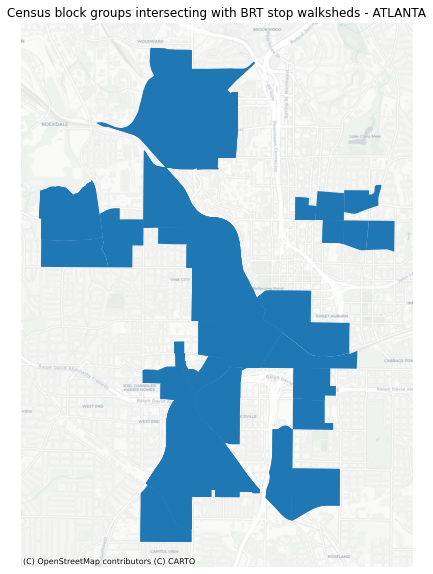

In [36]:
#ATLANTA map of census block groups of interest
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add isochrones
BG_ATL.plot(ax=ax,
               legend=True,
               zorder=20)

# no axis
ax.axis('off')

# title
ax.set_title('Census block groups intersecting with BRT stop walksheds - ATLANTA')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

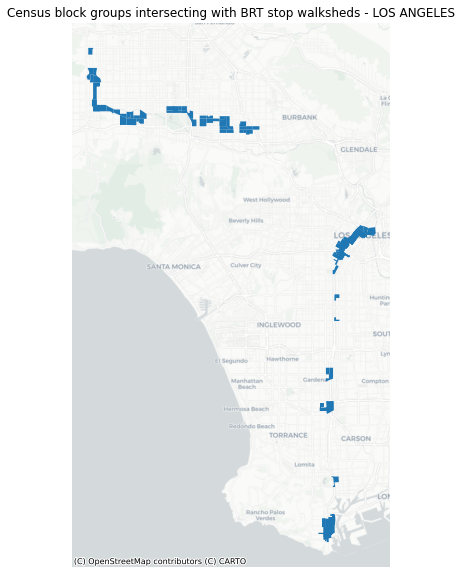

In [37]:
#LOS ANGELES map of census block groups of interest
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add isochrones
BG_LA.plot(ax=ax,
               legend=True,
               zorder=20)

# no axis
ax.axis('off')

# title
ax.set_title('Census block groups intersecting with BRT stop walksheds - LOS ANGELES')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

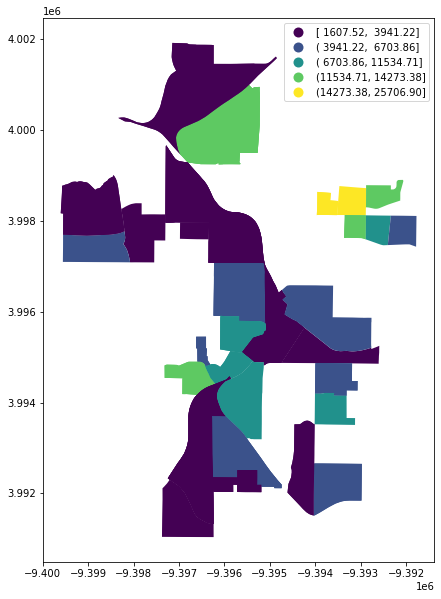

In [42]:
ax = BG_ATL.plot(BG_ATL['Population Density'],
        figsize=(10,10),
        scheme='natural_breaks',
        legend=True)

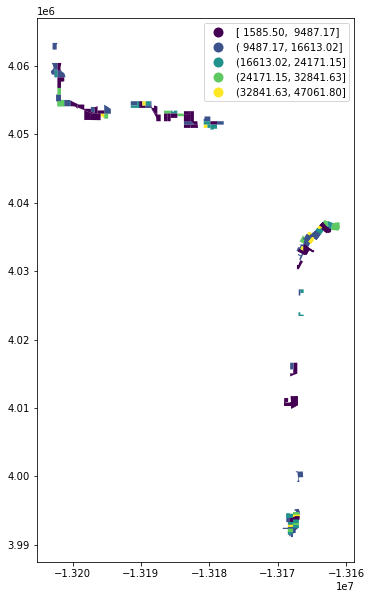

In [43]:
ax = BG_LA.plot(BG_LA['Population Density'],
        figsize=(10,10),
        scheme='natural_breaks',
        legend=True)

## Next Steps
Our process is much more streamlined, and we were able to bring both cities into a single notebook, which will make it much easier to replicate our work going forward. Based on our midterm feedback, we're thinking about how to score/evaluate each route. Given the academic quarter's time constraints, we don't expect to invent a new, rigorous equity index for transportation routes, but we'll aim to come up with a scoring system to compare the five routes in our project against each other. We will likely need to draw in additional data for this, which should be simple with our better data import process.

## Credits
Aziz built out stop information for LA's BRT lines from Metro's mess of data and identified a problem with the nativity census data we were using (to be fixed for next week). Andrew added code to simplify the census data cleanup and merge process, and modified the spatial join to use block group centroids. We both worked together to bring our data and code into alignment so that it would run in a single notebook and troubleshooted issues.